So an approach that I talked to professor heaton about was having the program learn its OWN odes.  This means that each patient will be able to have a personalized model if nessecary even though there should be some type of base model. we are going for this apporach because a lot of the models I've look at from papers and have adpated in my current odes truthfully, bad generalizations of what the ode should look like. we truthfully don't know what the best ode should look like so why not let the computer learn what it should be for each patient. 

what im doing here is using the savgol_filter as a way to smooth my data, then take the derivatve of that smoothed data so that we can understand how 
we should adjust our parameters 

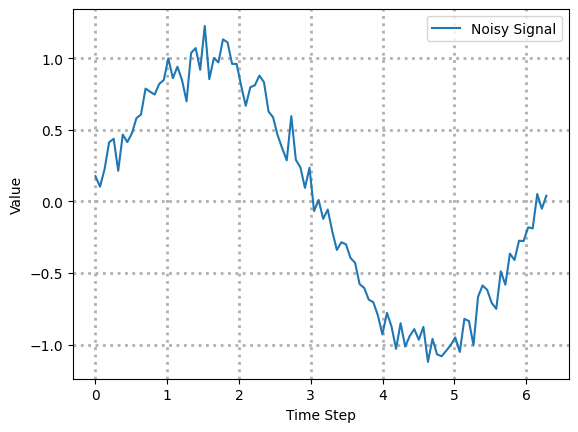

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

np.random.seed(0)
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x) + np.random.normal(0, 0.1, x.size)

plt.plot(x, y, label='Noisy Signal')
plt.grid(lw=2,ls=':')
plt.xlabel('Time Step')
plt.ylabel("Value")
plt.legend()
plt.show()

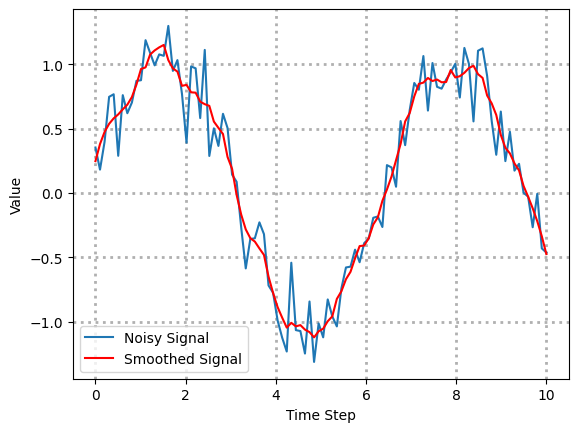

In [5]:
window_size = 11
poly_order = 3
y_smooth = savgol_filter(y, window_size, poly_order)

plt.plot(x, y, label='Noisy Signal')
plt.plot(x, y_smooth, label='Smoothed Signal', color='red')
plt.grid(lw=2,ls=':')
plt.xlabel('Time Step')
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
def estimate_derivative(t, x, window=11, poly=3):
    
    t = np.asarray(t)
    x = np.asarray(x)
    if x.ndim == 1: # if 1 dimensinal 
        x = x[:, None]  # make sure its no longer 1 - dimensional
    dt = np.median(np.diff(t)) #diff will find the difference between all the elements in the list/array, then median will return the middle value
    # sg filter needs odd window and >= poly+2
    window = max(window, poly + 2 + (poly + 2) % 2) | 1 #determining the size of the window (small - ovefit, big - miss trends)
    x_smooth = savgol_filter(x, window_length=window, polyorder=poly, axis=0, mode='mirror') 
    dxdt = savgol_filter(x, window_length=window, polyorder=poly, deriv=1, delta=dt, axis=0, mode='mirror')
    return x_smooth, dxdt
#returns smoothed data and derivative of smoothed data
#derivative tells us the slope of the error function with respect to the current parameters. the slope tells us how we should adjust out learning parameters

The next function I'm using helps us to understand what are the terms that captures relevant interactions between the varibales we have choosen

In [ ]:
def pick_terms(t, Phi, y, win = 10, stride = 5):
    t = np.asarray(t), y = np.asarray(y), Phi = np.asarray(Phi)
    dt = np.diff(t)
    rows = []
    rhs = []
    for i in range(0, len(t) - win - 1, stride):
        j = i + win 
        integral = np.trapezoid(Phi[i:j+1,:], t[i:j+1], axis = 0)
        rows.append(integral)
        rhs.append(y[j]-y[i])
    A = np.vstack(rows) if rows else np.zeros((0, Phi.shape[1]))
    b = np.asarray(rhs).ravel()
    return A,b
    

what this is doing is say we have a group of canindate terms for example [t/1-k(Tumor growth), r_ET (effect kill), r_EP(PD-L1 blockage rate)] we store that in the array Phi, then we are integrating those terms overs not over one long interval but over a group chopped up intervals with respect to the stride and window. From there we get an output of the coefficients that correspond to the "importance" of that term, allowing some terms to be zero'ed out. Our rhs corresponds to the observed change we see in our data ( for example, effector cell count) which we could get from the function above. so we get all the parts we need to solve Ax= b where x is the parameters that tell us the importance of terms allowing us to learn the ode.

Now we have to make a function that actually solves this Ax = b. I think when we do this we have to consider some things. we have to make sure the sign of the terms are the correct signs, like the immuno therapy should have a negative sign (-E*T). Then we also have to make sure we can allow terms to be 0 if they are irrelevant 

In [ ]:
def solve